### AI
#### Goal : To Develop AI Model to detect text present on Model or not

In [1]:
#pip install Segment Anything Model
!pip install git+https://github.com/facebookresearch/segment-anything.git --quiet

In [2]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import cv2
import pytesseract
from segment_anything import sam_model_registry, SamPredictor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))           

/kaggle/input/linkdine/1_Overlap.png
/kaggle/input/linkdine/5_NoOverlap.png
/kaggle/input/linkdine/7_Overlap.png
/kaggle/input/linkdine/4_Overlap.png
/kaggle/input/linkdine/2_NoOverlap.png
/kaggle/input/linkdine/6_Overlap.png
/kaggle/input/linkdine/3_NoOverlap.png
/kaggle/input/segment-anything-models/sam_vit_b_01ec64.pth
/kaggle/input/segment-anything-models/sam_vit_l_0b3195.pth
/kaggle/input/segment-anything-models/sam_vit_h_4b8939.pth
/kaggle/input/face-detect/haarcascade_frontalface_default.xml


# Helping Functions

In [3]:
# https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
# def show_box(box, ax):
#     x0, y0 = box[0], box[1]
#     w, h = box[2] - box[0], box[3] - box[1]
#     ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   



# Reading single image and converting in RGB

In [4]:
image = cv2.imread('/kaggle/input/linkdine/1_Overlap.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Setting up class

In [5]:
# For face Detection
face_cascade = cv2.CascadeClassifier('/kaggle/input/face-detect/haarcascade_frontalface_default.xml')

# Segment anthing model setting up
sam_checkpoint = "/kaggle/input/segment-anything-models/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)

In [6]:
# Process the image to produce an image embedding by calling SamPredictor.set_image
predictor.set_image(image)

# getting co ordinates of face
face_rects = face_cascade.detectMultiScale(image ,scaleFactor=1.2, minNeighbors=5)

# Setting points for where we want to grab mask
input_point = np.array([[face_rects[0][0] + face_rects[0][2]/2 , face_rects[0][1]+face_rects[0][2]/2]])
input_label = np.array([1])

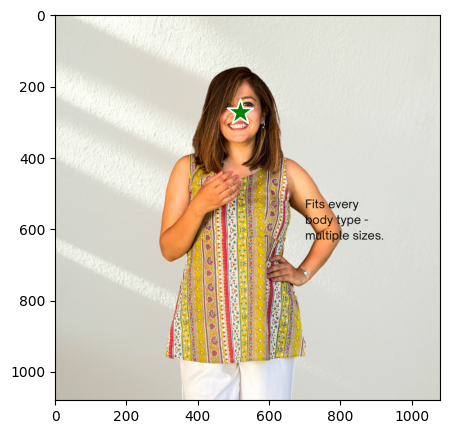

In [7]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

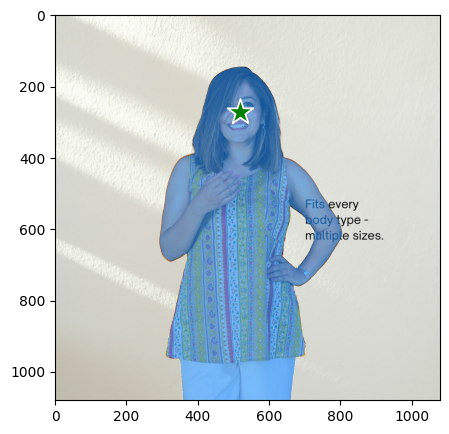

In [8]:
# model returns masks, quality predictions for those masks
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

# grabbing best mask that is 3rd mask 

plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(masks[2], plt.gca())
show_points(input_point, input_label, plt.gca())
plt.show()  

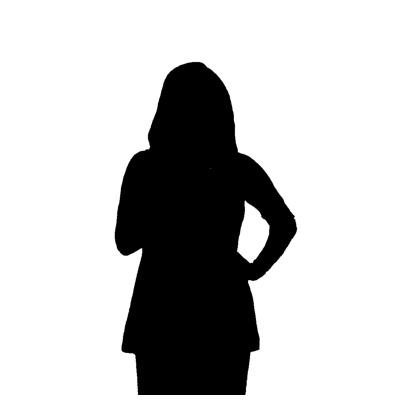

In [9]:
mask_output, score = masks[2], scores[2]

result_mask = np.uint8(mask_output)
 
#Show mask    
plt.figure(figsize=(5,5))
plt.imshow(result_mask, cmap=plt.get_cmap("binary"))
plt.axis('off')
plt.show()

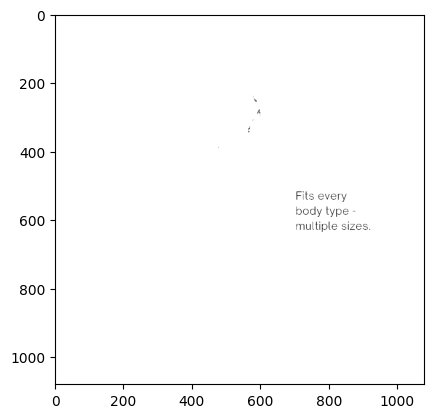

In [10]:
# Reading image
img_full = cv2.imread('/kaggle/input/linkdine/1_Overlap.png' ,0)

# Setting threshold for detect test
ret, sep_thresh = cv2.threshold(img_full,1,255,cv2.THRESH_BINARY)
plt.imshow(sep_thresh,cmap = 'gray')

In [11]:
# text Detection
text = pytesseract.image_to_data(sep_thresh ,output_type='dict')

# Converting data into Dataframe
df = pd.DataFrame(text)

# text is present in level 5 so filtering out
for i in (df[df['level']==5]).to_numpy():
    left = int(i[6])
    top = int(i[7])
    width = int(i[8])
    height = int(i[9])
    
    # filling rectangle around text
    cv2.rectangle(sep_thresh , (left,top) ,(left+width , top+height) , (0,255,0) , -1)

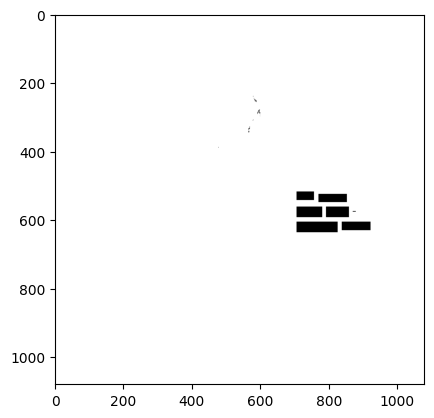

In [12]:
# Inverting pixel
inverted_img = cv2.bitwise_not(sep_thresh)
plt.imshow(inverted_img, cmap=plt.get_cmap("binary"))

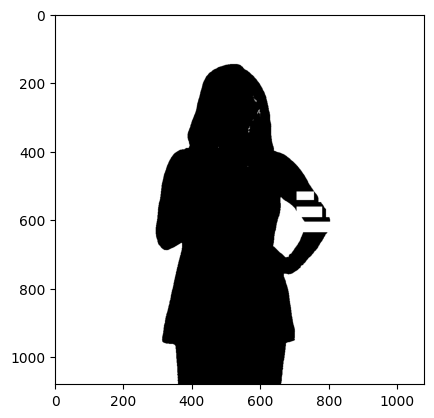

In [13]:
# Subtraction of inverted image but applying on mask region i.e result from sam model
fg = cv2.bitwise_or(result_mask ,sep_thresh ,mask = result_mask )

plt.imshow(fg, cmap=plt.get_cmap("binary"))

In [14]:
# Normalizing two images i.e subtracted image and mask image
fg = fg/fg.max()
result_mask = result_mask/result_mask.max()

In [15]:
# calculating mse to know images are different or not
mse = np.mean((result_mask - fg) ** 2)
print(mse)

0.005203290124247876


In [16]:
# writing in function
def Overlap_Or_Not(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    predictor.set_image(image)
    face_rects = face_cascade.detectMultiScale(image ,scaleFactor=1.2, minNeighbors=5) 
    input_point = np.array([[face_rects[0][0] + face_rects[0][2]/2 , face_rects[0][1]+face_rects[0][2]/2]])
    input_label = np.array([1])
    
    
    masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True)
    
    
    #Mask with best score
    mask_output, score = masks[2], scores[2]

    #Convert types - boolean to uint8
    result_mask = np.uint8(mask_output)
    
    
    img_full = cv2.imread(path ,0)
    
    
    
    ret, sep_thresh = cv2.threshold(img_full,5,125,cv2.THRESH_BINARY)

    
    
    text = pytesseract.image_to_data(sep_thresh ,output_type='dict')
    df = pd.DataFrame(text)

    for i in (df[df['level']==5]).to_numpy():
        left = int(i[6])
        top = int(i[7])
        width = int(i[8])
        height = int(i[9])
        cv2.rectangle(sep_thresh , (left,top) ,(left+width , top+height) , (0,255,0) , -1)
    
    
    inverted_img = cv2.bitwise_not(sep_thresh)
    
    
    fg = cv2.bitwise_or(result_mask ,sep_thresh ,mask = result_mask )
    fg = fg/fg.max()
    result_mask = result_mask/result_mask.max()

    
    mse = np.mean((result_mask - fg) ** 2)
    
    print("MSE is :" , mse)
    if (mse == 1) or (0.001>mse ):
        return "No_Overlap"
    else:
        return "Over_lap"
    


In [17]:
output = Overlap_Or_Not('/kaggle/input/linkdine/1_Overlap.png')
print(output)

MSE is : 0.005679628641975307
Over_lap


In [18]:
output = Overlap_Or_Not('/kaggle/input/linkdine/2_NoOverlap.png')
print(output)

MSE is : 0.0005914170644718793
No_Overlap


In [19]:
output = Overlap_Or_Not('/kaggle/input/linkdine/3_NoOverlap.png')
print(output)

MSE is : 0.0
No_Overlap


In [20]:
output = Overlap_Or_Not('/kaggle/input/linkdine/4_Overlap.png')
print(output)

MSE is : 0.0015810493278463646
Over_lap


In [21]:
output = Overlap_Or_Not('/kaggle/input/linkdine/5_NoOverlap.png')
print(output)

MSE is : 0.0
No_Overlap


In [22]:
output = Overlap_Or_Not('/kaggle/input/linkdine/6_Overlap.png')
print(output)

MSE is : 0.0027723202194787377
Over_lap


In [23]:
output = Overlap_Or_Not('/kaggle/input/linkdine/7_Overlap.png')
print(output)

MSE is : 0.0028904348971193414
Over_lap
